# Heat Stress Calculation example

This notebook illustrates the calculation of heat stress indices with CMIP6-CORDEX simulations.
For simplicity, we calculate just one year for the season JJAS of one single model run.

In [1]:
## Expand JVM memory
options(java.parameters = "-Xmx8000m")


## Climate4R
library(loadeR)
library(visualizeR)
library(convertR)
# HeatStress
library(HeatStress)

Loading required package: rJava



Loading required package: loadeR.java

Java version 23x amd64 by N/A detected

The maximum JVM heap space available is: 7.81 GB

NetCDF Java Library Version: 4.6.0-SNAPSHOT (Built-On: 20150423.1338) loaded and ready

You can manually set the NetCDF Java Library version before loading the package:
options(loadeR.java_forced_version = "X.Y.Z")
library(loadeR.java)

netCDF-Java CLASSPATH from bundled java package directory: /mnt/CORDEX_CMIP6_tmp/user_tmp/acasanueva/micromamba/envs/R4.3/lib/R/library/loadeR.java/java:/mnt/CORDEX_CMIP6_tmp/user_tmp/acasanueva/micromamba/envs/R4.3/lib/R/library/loadeR.java/java/netcdfAll-4.6.0-SNAPSHOT.jar

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.4 (2025-08-07) is loaded

Please use 'citation("loadeR")' to cite this package.

Loading required package: transformeR




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

Loading required package: udunits2

udunits system database read from /mnt/CORDEX_CMIP6_tmp/user_tmp/acasanueva/micromamba/envs/R4.3/lib/R/library/udunits2/share/udunits2.xml

convertR version 0.2.1 (2023-06-22) is loaded

  More information about the 'climate4R' ecosystem in: http://meteo.unican.es/climate4R


Attaching package: ‘convertR’


The following objects are masked from ‘package:loadeR’:

    hurs2huss, huss2hurs, tdps2hurs


Loading required package: magrittr

HeatStress version 1.0.8.1 (2019-07-01) is loaded

Use 'indexShow()' for an overview of the available heat indices



Check available heat stress indices in HeatStress package:

In [2]:
indexShow()

code,longname,indexfun,tas,dewp,hurs,wind,radiation,units
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>
wbt,Wet Bulb Temperature,wbt.Stull,1,0,1,0,0,degC
wbgt_shade,Wet Bulb Globe Temperature (shade),wbgt.Bernard,1,1,0,0,0,degC
wbgt_sun,Wet Bulb Globe Temperature (sun),wbgt.Liljegren,1,1,0,1,1,degC
swbgt,simplified wet bulb globe temperature,swbgt,1,0,1,0,0,degC
apparentTemp,apparent temperature,apparentTemp,1,0,1,1,0,degC
effectiveTemp,effective temperature,effectiveTemp,1,0,1,1,0,degC
humidex,humidex,humidex,1,0,1,0,0,degC
discomInd,discomfort index,discomInd,1,0,1,0,0,degC
hi,heat index,hi,1,0,1,0,0,degF


## Load model data and unit conversion

As an example, one model simulation is read for a short period. Unit conversion is performed with `udConverGrid`, a wrapper of the [UDUNITS](https://www.unidata.ucar.edu/software/udunits/) library.

In [3]:
ncml_file <- "../data_catalogs/CCLM6-0-1-URB_hs_vars.ncml"
di <- dataInventory(dataset = ncml_file)
names(di)

[2026-01-18 19:23:10.939597] Doing inventory ...



[2026-01-18 19:23:11.75189] Retrieving info for 'hurs' (2 vars remaining)

[2026-01-18 19:23:11.827607] Retrieving info for 'sfcWind' (1 vars remaining)

[2026-01-18 19:23:11.858257] Retrieving info for 'tas' (0 vars remaining)

[2026-01-18 19:23:11.893136] Done.



[1] "hurs"    "sfcWind" "tas"

In [4]:
str(di$tas)

List of 7
 $ Description: chr "Near-Surface Air Temperature"
 $ DataType   : chr "float"
 $ Shape      : int [1:3] 368184 406 418
 $ Units      : chr "K"
 $ DataSizeMb : num 249935
 $ Version    : logi NA
 $ Dimensions :List of 3
  ..$ time:List of 4
  .. ..$ Type      : chr "Time"
  .. ..$ TimeStep  : chr ".041666 days"
  .. ..$ Units     : chr "days since 1949-12-01 00:00:00"
  .. ..$ Date_range: chr "1980-01-01T00:00:00Z - 2021-12-31T23:00:00Z"
  ..$ rlat:List of 5
  .. ..$ Type       : chr "GeoY"
  .. ..$ Units      : chr "degrees"
  .. ..$ Values     : num [1:406] -23 -22.9 -22.8 -22.7 -22.6 ...
  .. ..$ Shape      : int 406
  .. ..$ Coordinates: chr "rlat"
  ..$ rlon:List of 5
  .. ..$ Type       : chr "GeoX"
  .. ..$ Units      : chr "degrees"
  .. ..$ Values     : num [1:418] -28 -27.9 -27.8 -27.7 -27.6 ...
  .. ..$ Shape      : int 418
  .. ..$ Coordinates: chr "rlon"


In [5]:
data_tas <- loadGridData(ncml_file, var="tas", years=2000, season = 6:9)

[2026-01-18 19:23:12.215406] Defining geo-location parameters

[2026-01-18 19:23:12.373184] Defining time selection parameters

[2026-01-18 19:23:14.257078] Retrieving data subset ...

[2026-01-18 19:24:05.529802] Done



In [6]:
data_tas <- udConvertGrid(data_tas, new.units = "degC")

In [7]:
str(data_tas)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "tas"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Near-Surface Air Temperature"
  ..- attr(*, "units")= chr "degC"
  ..- attr(*, "longname")= chr "tas"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:2928, 1:406, 1:418] 31.4 30.9 30.8 30.3 29.5 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 4
  ..$ x  : num [1:418] -28 -27.9 -27.8 -27.7 -27.6 ...
  ..$ y  : num [1:406] -23 -22.9 -22.8 -22.7 -22.6 ...
  ..$ lon: num [1:406, 1:418] -9.9 -9.95 -10 -10.04 -10.09 ...
  ..$ lat: num [1:406, 1:418] 22.4 22.5 22.6 22.7 22.8 ...
  ..- attr(*, "projection")= chr "RotatedPole"
  ..- attr(*, "grid_mapping_name")= chr "rotated_latitude_longitude"
  ..- attr(*, "grid_north_pole_latitude")= chr "39.25"
  ..- attr(*, "grid_north_pole_longitude")= chr

[2026-01-18 19:25:13.447578] - Computing climatology...

[2026-01-18 19:25:25.325426] - Done.



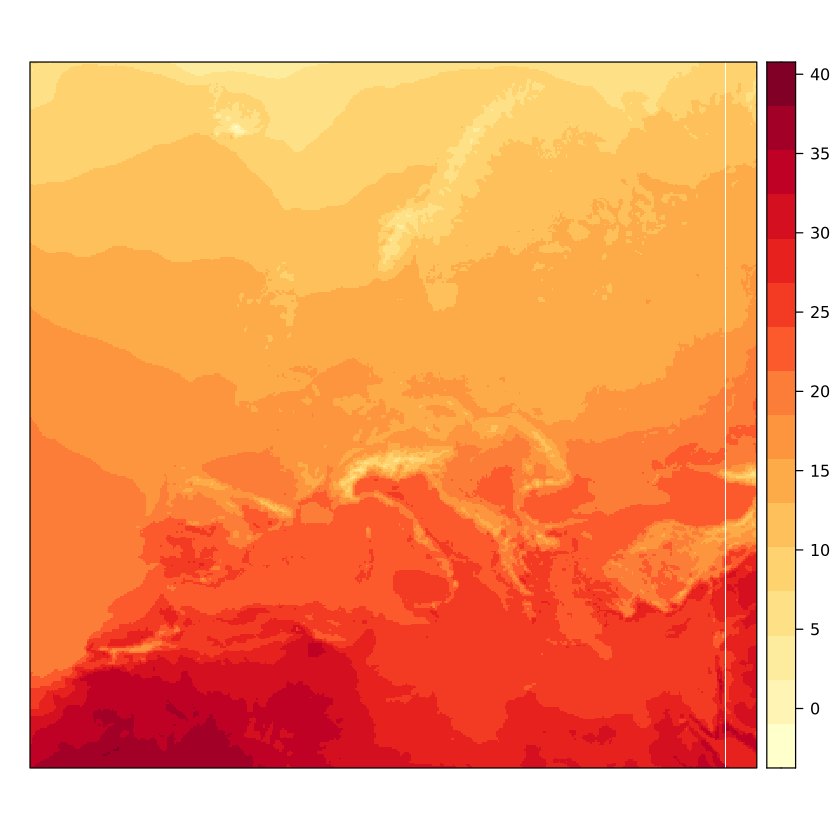

In [8]:
spatialPlot(climatology(data_tas), color.theme = "YlOrRd")

In [9]:
data_hurs <- loadGridData(ncml_file, var="hurs", years=2000, season = 6:9)

[2026-01-18 19:25:26.246127] Defining geo-location parameters



[2026-01-18 19:25:26.354803] Defining time selection parameters

[2026-01-18 19:25:27.941186] Retrieving data subset ...

[2026-01-18 19:26:20.947671] Done



In [10]:
str(data_hurs)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "hurs"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Near-Surface Relative Humidity"
  ..- attr(*, "units")= chr "%"
  ..- attr(*, "longname")= chr "hurs"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:2928, 1:406, 1:418] 8.25 9.58 11.55 13.18 14.69 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 4
  ..$ x  : num [1:418] -28 -27.9 -27.8 -27.7 -27.6 ...
  ..$ y  : num [1:406] -23 -22.9 -22.8 -22.7 -22.6 ...
  ..$ lon: num [1:406, 1:418] -9.9 -9.95 -10 -10.04 -10.09 ...
  ..$ lat: num [1:406, 1:418] 22.4 22.5 22.6 22.7 22.8 ...
  ..- attr(*, "projection")= chr "RotatedPole"
  ..- attr(*, "grid_mapping_name")= chr "rotated_latitude_longitude"
  ..- attr(*, "grid_north_pole_latitude")= chr "39.25"
  ..- attr(*, "grid_north_pole_longitude")=

[2026-01-18 19:26:24.453177] - Computing climatology...

[2026-01-18 19:26:34.655253] - Done.



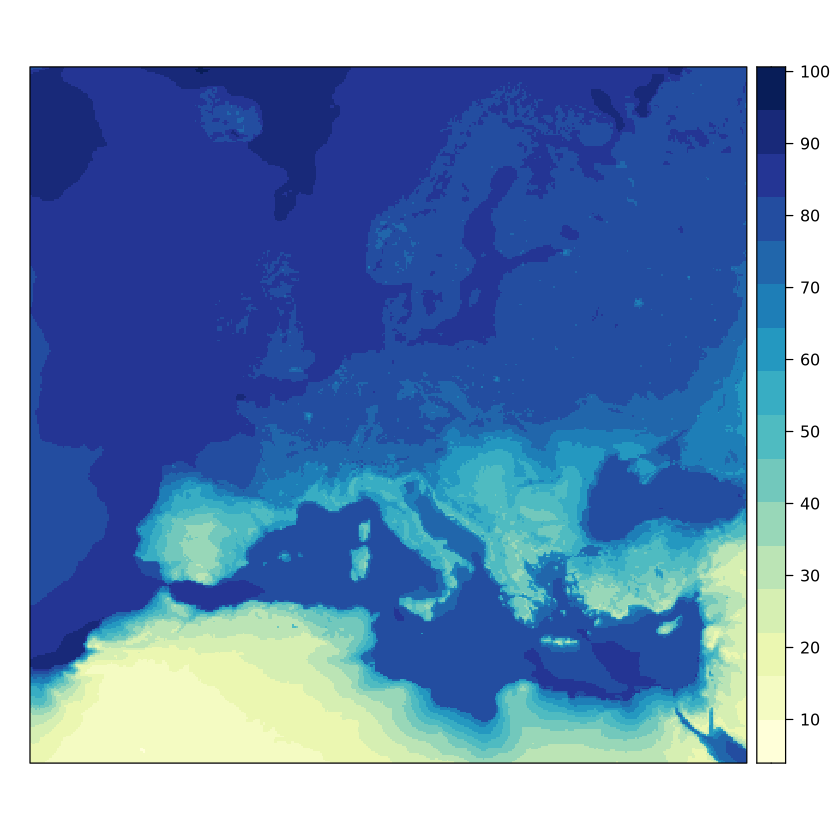

In [11]:
spatialPlot(climatology(data_hurs), color.theme = "YlGnBu")

## Landmask

Land-points are filtered with the land mask to avoid calculations on the sea.


In [12]:
landmask <- list.files(path = "/mnt/CORDEX_CMIP6_tmp/sim_data/CORDEX-CMIP6/DD/EUR-12/CLMcom-CMCC/ERA5/evaluation/r1i1p1f1/CCLM6-0-1-URB/v1-r1/fx/",
                       pattern = "^sftlf.*nc$",
                       recursive = TRUE,
                       full.names = TRUE)
print(landmask)

[1] "/mnt/CORDEX_CMIP6_tmp/sim_data/CORDEX-CMIP6/DD/EUR-12/CLMcom-CMCC/ERA5/evaluation/r1i1p1f1/CCLM6-0-1-URB/v1-r1/fx//sftlf/v20250201/sftlf_EUR-12_ERA5_evaluation_r1i1p1f1_CLMcom-CMCC_CCLM6-0-1-URB_v1-r1_fx.nc"


In [13]:
lm <- loadGridData(dataset = landmask, var = "sftlf")

[2026-01-18 19:26:35.377089] Defining geo-location parameters

[2026-01-18 19:26:35.446912] Defining time selection parameters

NOTE: Undefined Dataset Time Axis (static variable)

[2026-01-18 19:26:35.452378] Retrieving data subset ...

[2026-01-18 19:26:35.5331] Done



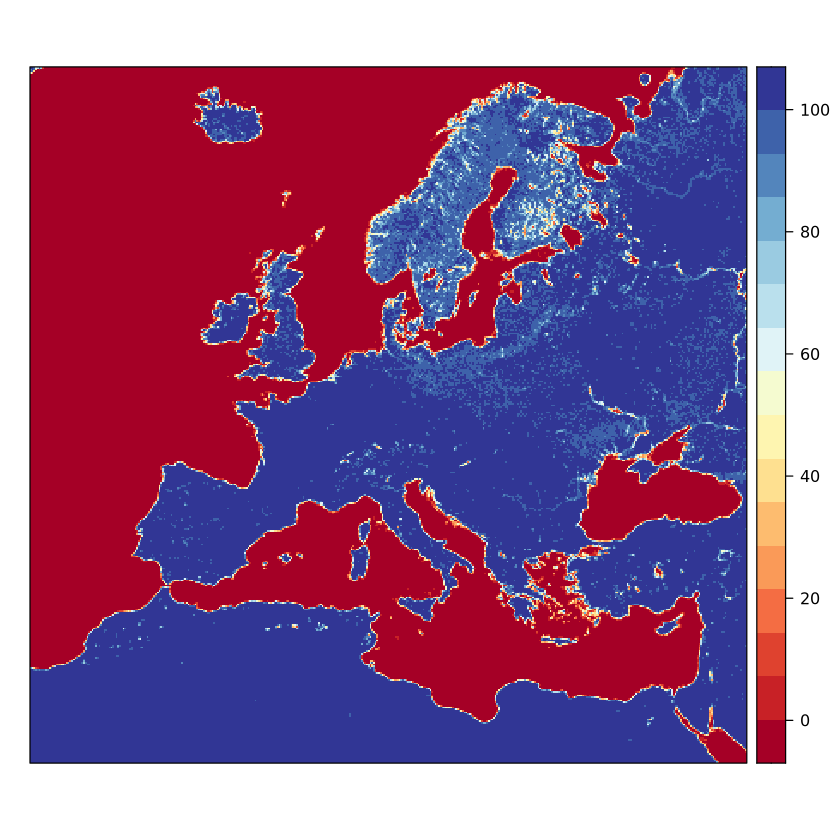

In [14]:
spatialPlot(lm)

The landmask is used to take only land gridboxes in the RCM, which will subsequently compared with the reference dataset. We set a land area fraction threshold (here 50%) below which we consider the entire pixel as "sea":

In [15]:
lm.bin <- binaryGrid(lm, condition = "GE", threshold = 50, values = c(NA,1))

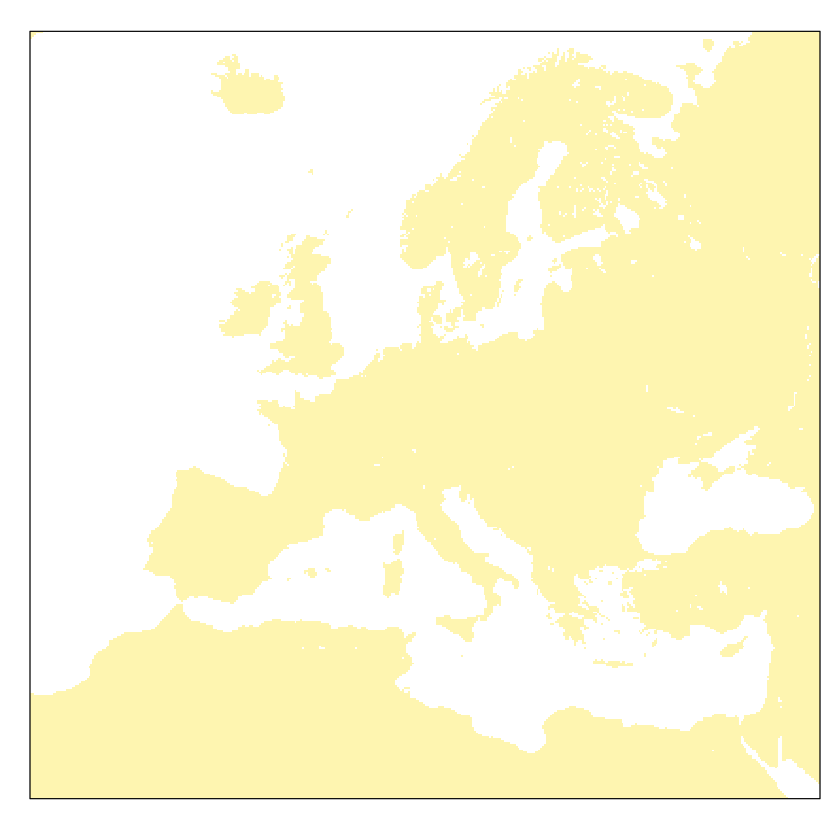

In [16]:
spatialPlot(lm.bin, colorkey = FALSE)

In [17]:
lm_val <- lm.bin$Data
ntime <- length(getRefDates(data_tas))
ntime

[1] 2928

In [18]:
lm_full <- data_tas
for (i in 1:ntime) {
  lm_full$Data[i,,] <- lm_val
}

In [19]:
data_tas_filtered <- gridArithmetics(data_tas, lm_full, operator= "*")
data_hurs_filtered <- gridArithmetics(data_hurs, lm_full, operator= "*")
data_tas <- data_hurs <- NULL 

[2026-01-18 19:31:56.065586] - Computing climatology...

[2026-01-18 19:32:03.841907] - Done.



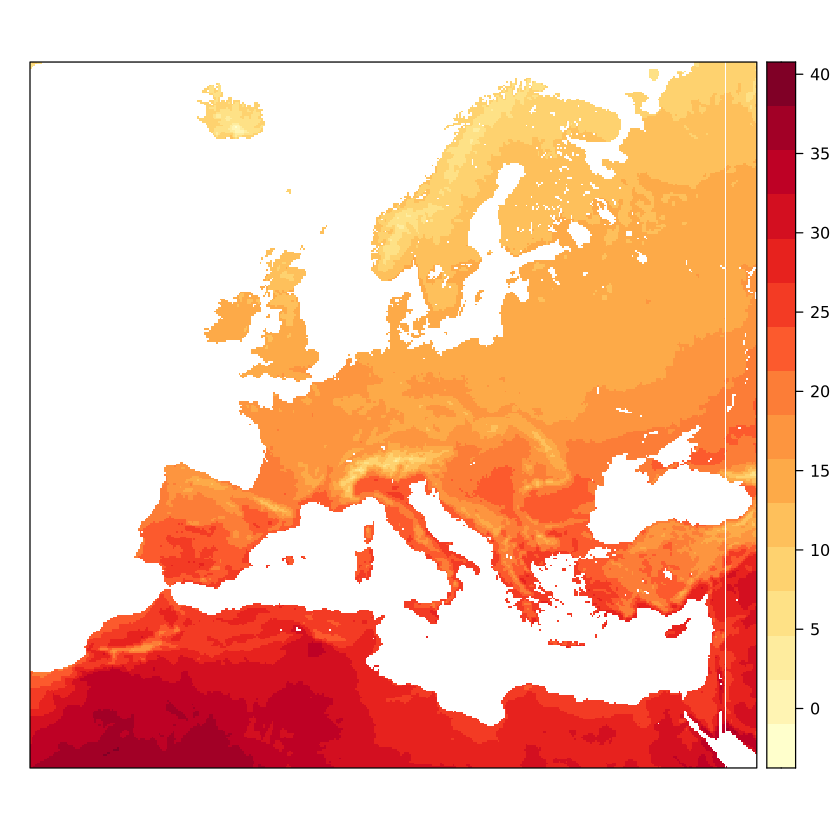

In [20]:
spatialPlot(climatology(data_tas_filtered), color.theme = "YlOrRd")

[2026-01-18 19:32:06.965738] - Computing climatology...

[2026-01-18 19:32:16.282254] - Done.



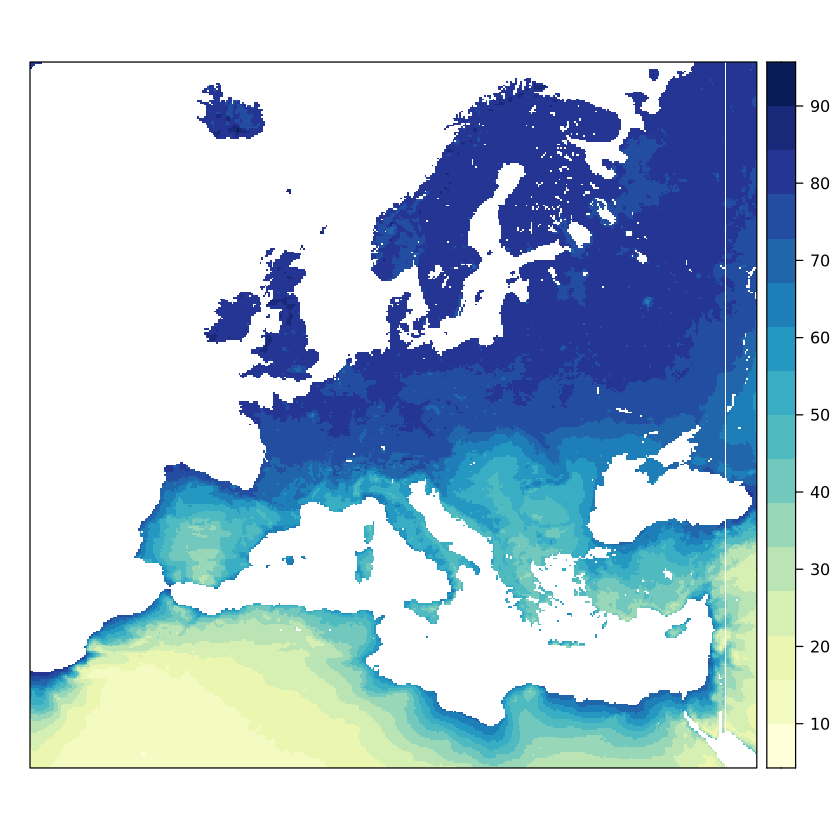

In [21]:
spatialPlot(climatology(data_hurs_filtered), color.theme = "YlGnBu")

## Heat stress calculation

The HeatStress package is used to calculate one exemplary heat stress index. Here simplified wet bulb temperature is calculated, which requires air temperature and relative humidity. Note that other indices require dew point temperature, which can be derived from relative humidity with `hurs2tdps` in the [`convertR` package](https://github.com/SantanderMetGroup/convertR/blob/master/R/tdps2hurs.R).

In [22]:
wbgt <- data_tas_filtered
wbgt$Data <- swbgt(tas = data_tas_filtered$Data, hurs = data_hurs_filtered$Data)

In [23]:
#wbgt$Data <- wbgt$Data$data
wbgt$Variable$varName <- "swbgt"
attributes(wbgt$Variable)$description <- "Simplified Wet-Bulb Globe Temperature"
attributes(wbgt$Variable)$longname <- "swbgt"

### Graphical representations

`climatology` is used here to obtain the mean value of WBGT over the hourly time series. It is represented with `spatialPlot`:

[2026-01-18 19:32:48.963696] - Computing climatology...

[2026-01-18 19:32:57.163513] - Done.



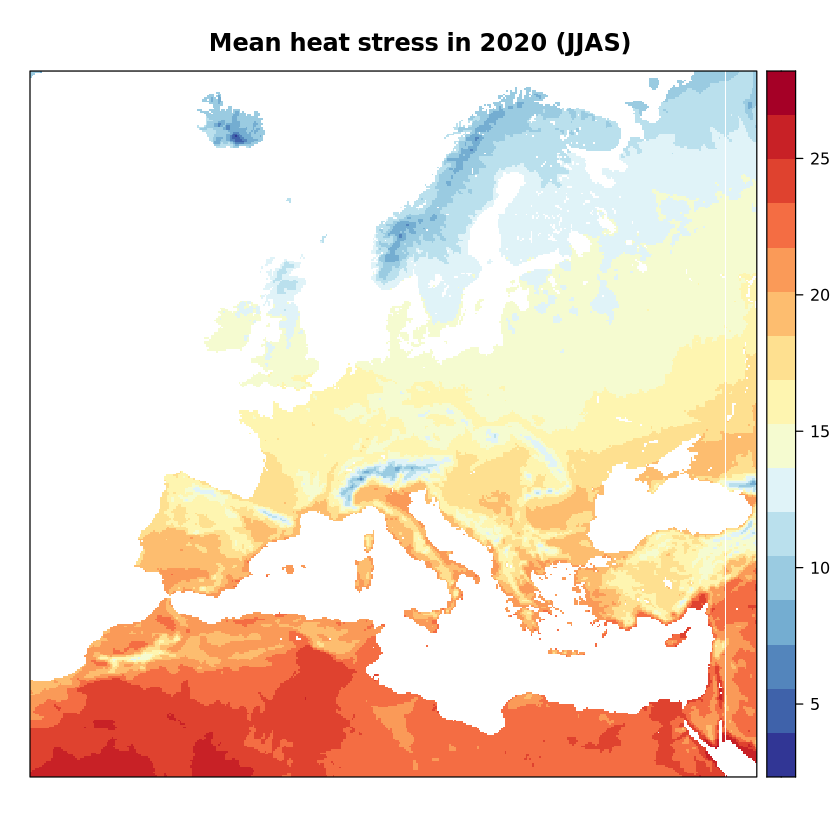

In [24]:
wbgt_dailymean <- climatology(wbgt) # by default mean over the whole period (hourly data)
spatialPlot(wbgt_dailymean, main = "Mean heat stress in 2020 (JJAS)", rev.colors = TRUE)

Here we calculate daily maximum and daily mininum values:

In [25]:
wbgt_dailymax <- suppressWarnings(aggregateGrid(wbgt, aggr.d = list(FUN = max, na.rm = TRUE)))
atrib_aux <- attributes(wbgt_dailymax$Data)
wbgt_dailymax$Data <- ifelse(is.infinite(wbgt_dailymax$Data), NA, wbgt_dailymax$Data)
attributes(wbgt_dailymax$Data) <- atrib_aux

[2026-01-18 19:33:02.056924] Performing daily aggregation...

[2026-01-18 19:36:46.145684] Done.



In [26]:
wbgt_dailymin <- suppressWarnings(aggregateGrid(wbgt, aggr.d = list(FUN = min, na.rm = TRUE)))
atrib_aux <- attributes(wbgt_dailymin$Data)
wbgt_dailymin$Data <- ifelse(is.infinite(wbgt_dailymin$Data), NA, wbgt_dailymin$Data)
attributes(wbgt_dailymin$Data) <- atrib_aux

[2026-01-18 19:36:51.442025] Performing daily aggregation...

[2026-01-18 19:40:35.161923] Done.



Next, the JJAS maximum value of daily minimum (nighttime) and daily maximum (daytime) heat stress is computed and plotted.

[2026-01-18 19:40:36.342266] - Computing climatology...



[2026-01-18 19:40:38.658145] - Done.

[2026-01-18 19:40:38.789326] - Computing climatology...

[2026-01-18 19:40:41.051615] - Done.

The input grid is a climatology: temporal resolution set to 'unknown'

The input grid is a climatology: temporal resolution set to 'unknown'



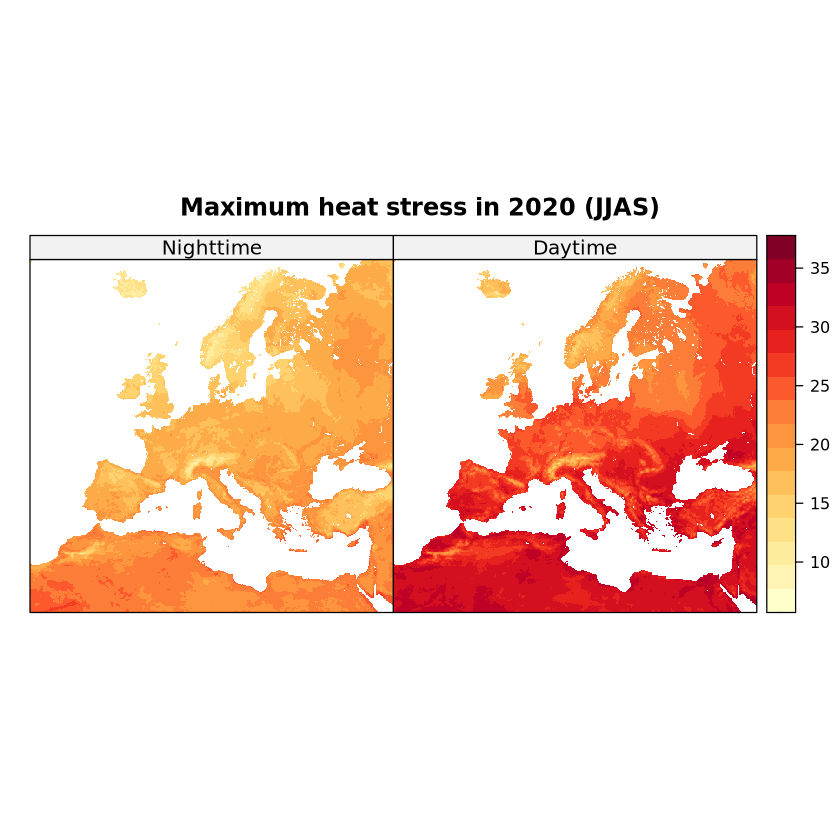

In [27]:
wbgt_dailymin_max <- suppressWarnings(climatology(wbgt_dailymin, clim.fun = list(FUN = max, na.rm = TRUE)))
wbgt_dailymax_max <- suppressWarnings(climatology(wbgt_dailymax, clim.fun = list(FUN = max, na.rm = TRUE)))
spatialPlot(bindGrid(wbgt_dailymin_max, wbgt_dailymax_max), main = "Maximum heat stress in 2020 (JJAS)", 
    as.table=TRUE, names.attr=c("Nighttime", "Daytime"), layout=c(2,1),color.theme = "YlOrRd")

#### Spatial subsetting:

Next, a spatial subsetting is performed and other statistics, such as percentiles are plotted.

In [28]:
wbgt_iberia <- subsetGrid(wbgt, lonLim = c(-22,-10), latLim = c(-13,-3))

In [29]:
wbgt90_iberia <- climatology(wbgt_iberia, clim.fun = list("quantile", probs = .9, na.rm = TRUE))

[2026-01-18 19:40:43.112786] - Computing climatology...

[2026-01-18 19:40:44.435987] - Done.



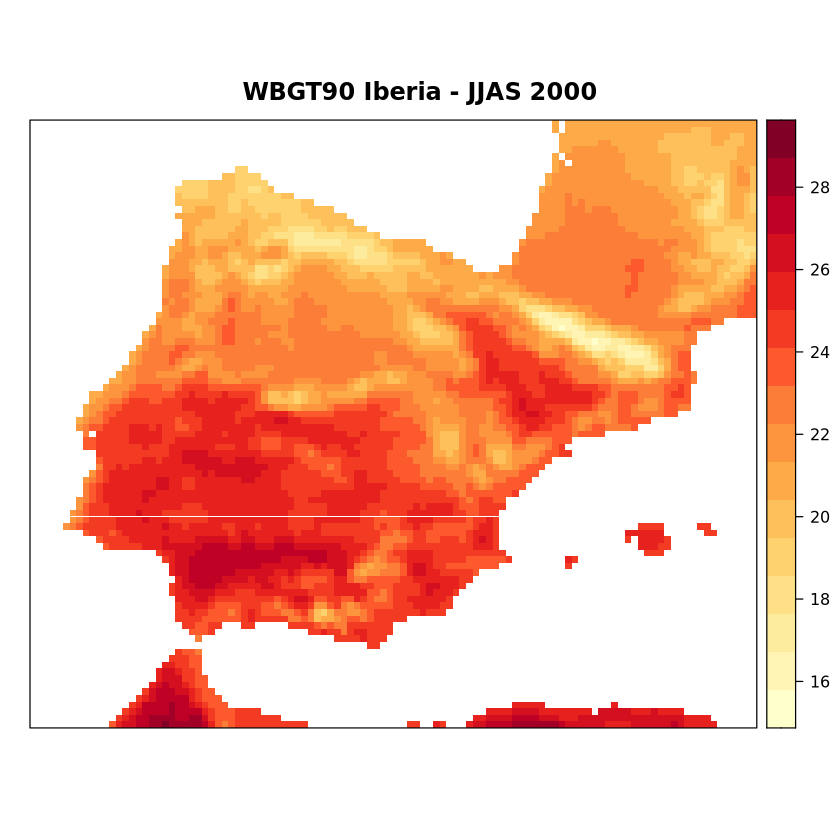

In [30]:
spatialPlot(wbgt90_iberia, color.theme = "YlOrRd",
            main = "WBGT90 Iberia - JJAS 2000")

#### Time series

A time series of the spatially averaged values for the Iberian subset:

pad applied on the interval: day



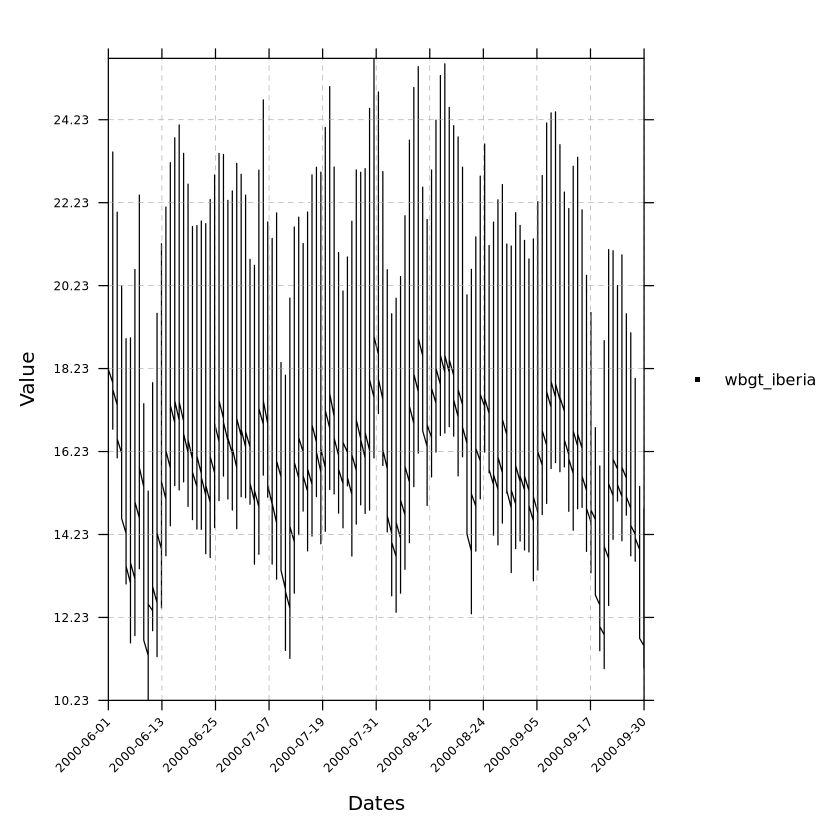

In [31]:
temporalPlot(wbgt_iberia)